Using Smopy means using OpenStreetMaps.  Per their usage rules: "Heavy use (e.g. distributing an app that uses tiles from openstreetmap.org) is forbidden without prior permission from the System Administrators. "

http://wiki.openstreetmap.org/wiki/Tile_usage_policy

In [124]:
import networkx as nx
import json
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 300

## Defining the functions

In [125]:
"""
    Each edge in the graph contains information about the road, including a list of points along this road. 
    We first create a function that returns this array of coordinates, for any edge in the graph.
"""

def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph, this function
    return an array of point coordinates along the road linking
    these two nodes."""
    return np.array(json.loads(g[n0][n1]['Json'])['coordinates'])

In [126]:
"""
    Our path contains connected nodes in the graph. 
    Every edge between two nodes is characterized by a list of points (constituting a part of the road). 
    Therefore, we need to define a function that concatenates the positions along every edge in the path. 
    A difficulty is that we need to concatenate the positions in the right order along our path. 
    We choose the order based on the fact that the last point in an edge needs to be close to the first point in the next edge.
"""

def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path)-1):
        p = get_path(path[i], path[i+1])
        if curp is None:
            curp = p
        if np.sum((p[0]-curp)**2) > np.sum((p[-1]-curp)**2):
            p = p[::-1,:]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [127]:
#plot nodes, a function sometimes called in plt_edge
def plt_node(a,b, color='black', size=1):
    
    for x,y in zip(a,b):
        ax.plot(x,y, 'o', color=color, ms=size, markeredgewidth=0.0)

In [128]:
def plt_edge(mini_path, color, plot_nodes=False, width=0.5):
    mini_linepath = get_full_path(mini_path)
    mx, my = map.to_pixels(mini_linepath[:,1], mini_linepath[:,0])
    ax.plot(mx, my, '-k', lw=width, color=color)
    if plot_nodes:
        plt_node(mx, my)

We will notably use the road path to compute its length. 
We first need to define a function that computes the distance between any two points in geographical coordinates. 
This function has been found in StackOverflow. 
http://stackoverflow.com/questions/8858838/need-help-calculating-geographical-distance

In [129]:
#returns in KILOMETERS
EARTH_R = 6372.8
def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points in 
    geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt(
        (np.cos(lat1) * np.sin(dlon)) ** 2
         + (np.cos(lat0) * np.sin(lat1) 
         - np.sin(lat0) * np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [130]:
#Now, we define a function computing a path's length.

#order of lats, lons was incorrect in tutorial! Corrected here
def get_path_length(path):
    return np.sum(geocalc(path[:-1,1], path[:-1,0], path[1:,1], path[1:,0]))

## Prep data

Load the data (a Shapefile dataset) with NetworkX. 
This dataset contains detailed information about all roads in San Francisco County. 
NetworkX's read_shp function returns a graph, where each node is a geographical position, 
and each edge contains information about the road linking the two nodes.

In lieu of Census data, SF Gov has a full, connected graph of streets that can be found here: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Streets-of-San-Francisco/4ugn-hf48

In [131]:
g = nx.read_shp('Road files/geo_export_4d537b7d-a470-4eb9-b147-1d0ea89e6b60.shp')

#being directional means being unable to find edges unless in correct order
#so switch to unidirected
g = g.to_undirected()

sg_all = list(nx.connected_component_subgraphs(g.to_undirected()))

#grab the biggest subgraph
max_len = -1
sg_final = sg_all[0]
for sg in sg_all:
    x = len(sg)
    if x > max_len:
        max_len = x
        sg_final = sg
        
sg = sg_final

In [132]:
#update graph by computing the distance between any two connected nodes
for n0, n1 in sg_final.edges_iter():
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edge[n0][n1]['distance'] = distance

Visualize the full city

Lowered zoom level to keep map size reasonable. (z = 12)


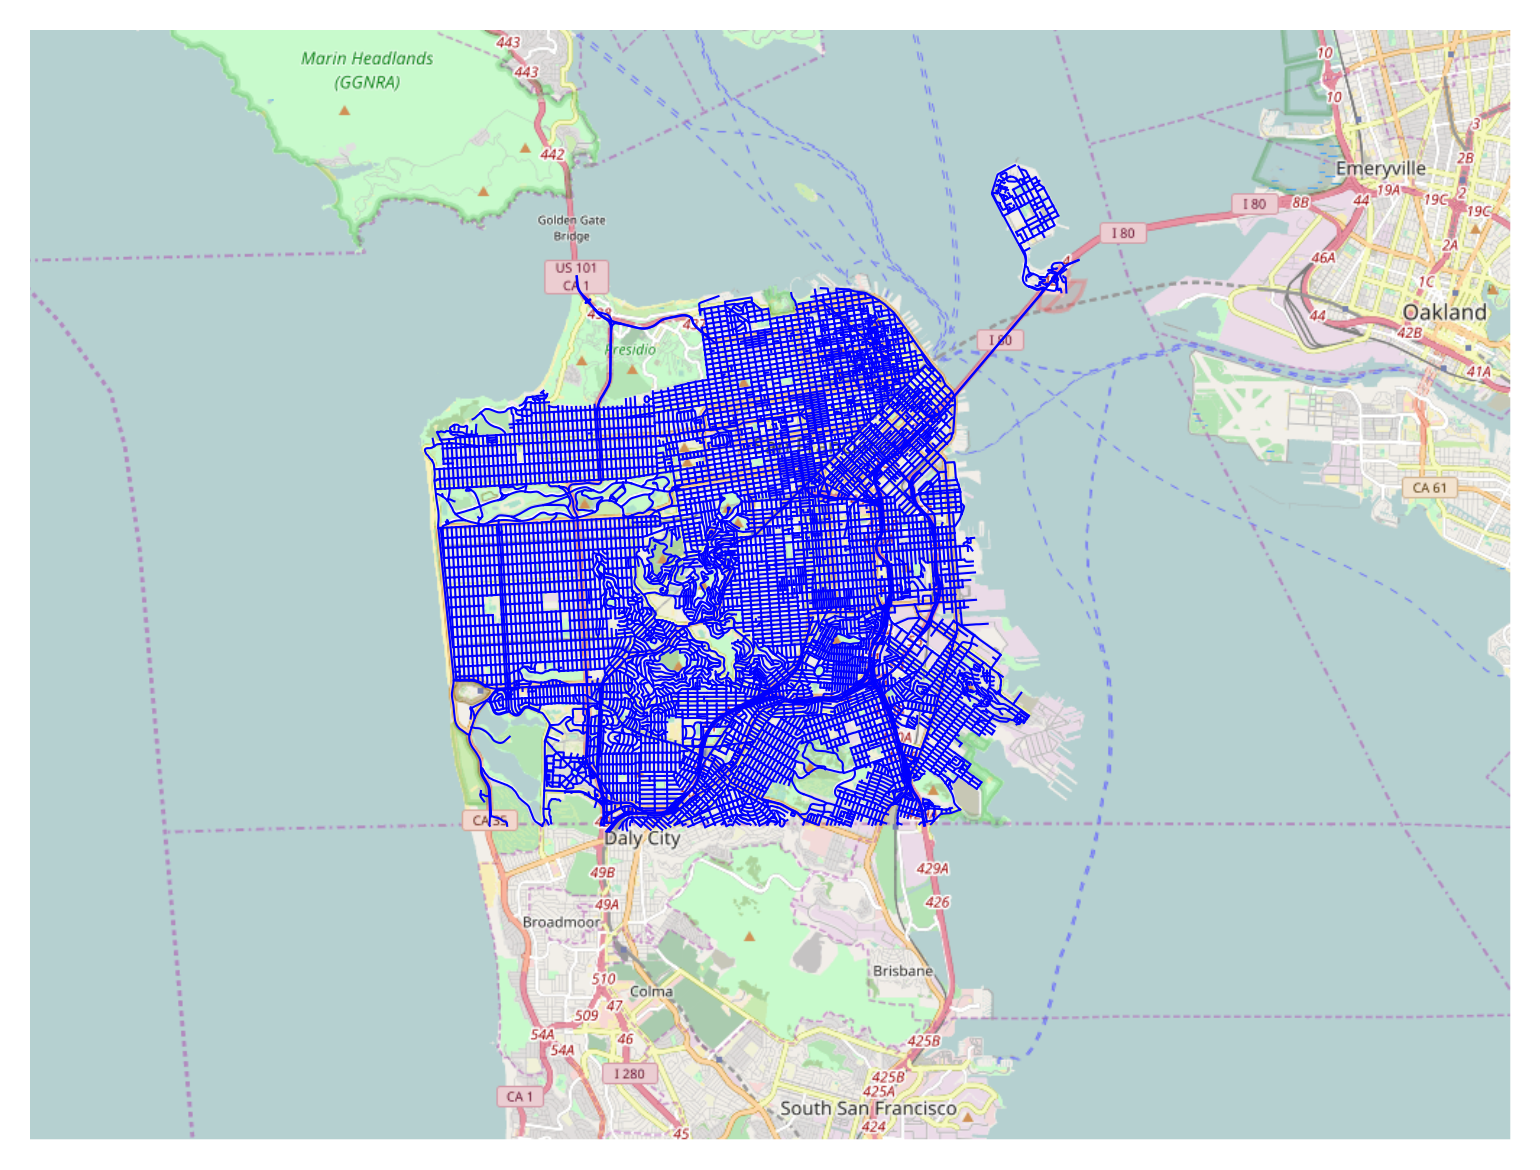

In [133]:
pos0 = (37.809776, -122.520686)
pos1 = (37.710163, -122.316753)
map = smopy.Map(pos0, pos1)
ax = map.show_mpl()

for e in sg_final.edges_iter():
    plt_edge(e, 'blue')

## Build route

In [134]:
#notable spots
home = (37.790461, -122.428311)
work = (37.789006, -122.409448)

## define the key areas of the route
start = home
end = home
target = [(37.800509, -122.426759), (37.800740, -122.426124)]

In [135]:
# find the two nodes in the graph that are closest to the two requested positions
nodes = np.array(sg_final.nodes())

# Get the closest nodes in the graph.
start_i = np.argmin(np.sum((nodes[:,::-1] - start)**2, axis=1))
end_i = np.argmin(np.sum((nodes[:,::-1] - end)**2, axis=1))
target_i = [np.argmin(np.sum((nodes[:,::-1] - t)**2, axis=1)) for t in target]

In [136]:
def build_route(a,b):
    segment = nx.shortest_path(sg_final, 
                        source=tuple(nodes[a]), 
                        target=tuple(nodes[b]),
                        weight='distance')
    return segment[1:]

# Compute the shortest path in three parts:

#start -> target
path = [tuple(nodes[start_i])]
path.extend(build_route(start_i, target_i[0]))

#target points
for ti in range(len(target_i)-1):
    path.extend(build_route(target_i[ti], target_i[ti+1]))

#target -> end
path.extend(build_route(target_i[-1], end_i))

In [137]:
"""
    The itinerary has been computed. 
    The path variable contains the list of edges that form the shortest path between our two positions. 
    Now, we can get information about the itinerary with Pandas. 
    The dataset has a few fields of interest, including the name and type (State, Interstate, etc.) of the roads.
"""

roads = pd.DataFrame([sg.edge[path[i]][path[i + 1]] 
                      for i in range(len(path) - 1)], 
                     columns=['distance', 'nhood', 'streetname'])
roads

,distance,nhood,streetname
0,0.099021,Pacific Heights,LAGUNA ST
1,0.098922,Pacific Heights,LAGUNA ST
2,0.099296,Pacific Heights,LAGUNA ST
3,0.146190,Pacific Heights,JACKSON ST
4,0.099084,Pacific Heights,OCTAVIA ST
5,0.103421,Pacific Heights,OCTAVIA ST
6,0.146458,Pacific Heights,BROADWAY
7,0.146227,Pacific Heights,BROADWAY
8,0.107531,Pacific Heights,FRANKLIN ST
9,0.104414,Pacific Heights,FRANKLIN ST


In [138]:
"""
    Here is the total length (IN KILOMETERS) of this itinerary.
"""

print('km: ' + str(roads['distance'].sum()))
print('mi: ' + str(roads['distance'].sum() * 0.621371))

km: 3.1422440116020978
mi: 1.952499303733207


Lowered zoom level to keep map size reasonable. (z = 16)


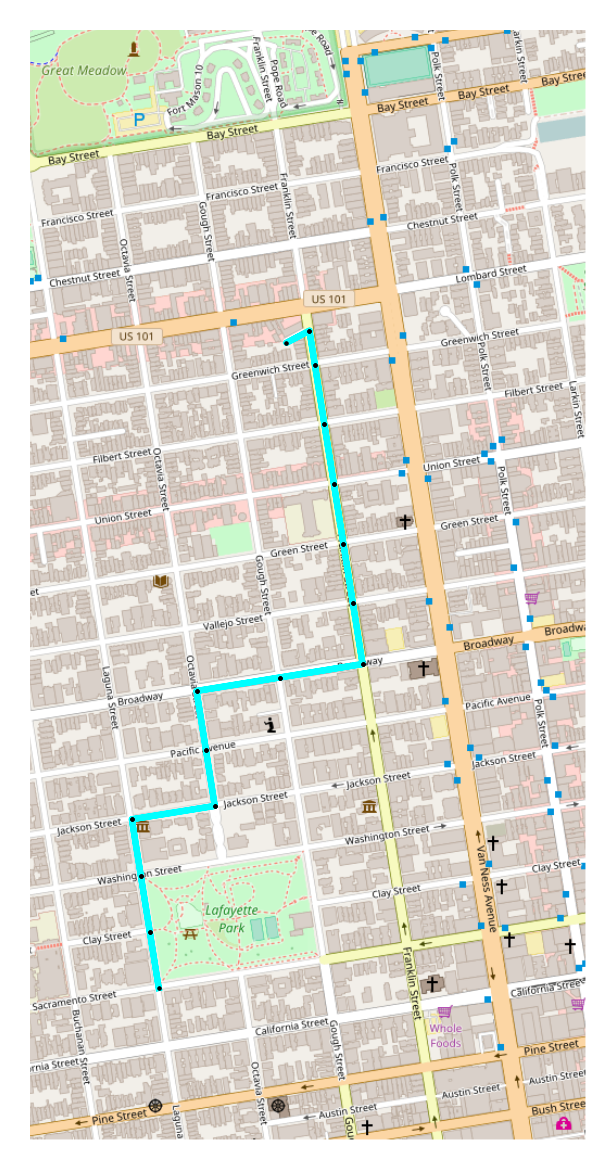

In [139]:
"""
    Finally, let display the itinerary on the map. We first retrieve the map with Smopy.
"""
#need to pull an appropriate window size for graphing
#this finds the lowest & highest lat/lon even if not directly paired
ll_lat = home[0]
ll_lon = home[1]
ur_lat = home[0]
ur_lon = home[1]

for p in path:
    if p[1] < ll_lat:
        ll_lat = p[1]
    if p[0] < ll_lon:
        ll_lon = p[0]
    if p[1] > ur_lat:
        ur_lat = p[1]
    if p[0] > ur_lon:
        ur_lon = p[0]


map = smopy.Map(path_ll, path_ur)

ax = map.show_mpl()
plt_edge(path, 'cyan', True, width=1.5)

## scratch

In [98]:
path

[(-122.42909226863561, 37.790459499242409),
 (-122.4292698163706, 37.791338637604234),
 (-122.42944719219173, 37.79221689795107),
 (-122.42962524216996, 37.79309847601998),
 (-122.42798314986253, 37.79330747788941),
 (-122.42815905012174, 37.79418740132096),
 (-122.42834448364005, 37.79510561077808),
 (-122.42669959984339, 37.795316271664895),
 (-122.42505730453816, 37.795526577000174),
 (-122.42524987464724, 37.79648130300052),
 (-122.42543686649972, 37.79740835145034),
 (-122.42562550396799, 37.798343536753706),
 (-122.42581353098511, 37.79927567111598),
 (-122.42600124861936, 37.800206248343216),
 (-122.42610916819469, 37.80074122472601),
 (-122.42656373497503, 37.80055160986177),
 (-122.42656373497503, 37.80055160986177),
 (-122.42610916819469, 37.80074122472601),
 (-122.42610916819469, 37.800741224726011),
 (-122.42600124861936, 37.800206248343216),
 (-122.42581353098511, 37.79927567111598),
 (-122.42562550396799, 37.798343536753706),
 (-122.42543686649972, 37.79740835145034),
 (-

In [102]:
#need to pull an appropriate window size for graphing
#this finds the lowest & highest lat/lon even if not directly paired
ll_lat = home[0]
ll_lon = home[1]
ur_lat = home[0]
ur_lon = home[1]

for p in path:
    if p[1] < ll_lat:
        ll_lat = p[1]
    if p[0] < ll_lon:
        ll_lon = p[0]
    if p[1] > ur_lat:
        ur_lat = p[1]
    if p[0] > ur_lon:
        ur_lon = p[0]

path_ll = (ll_lat, ll_lon)
path_ur = (ur_lat, ur_lon)
        
        
print(path_ll)
print(path_ur)

(37.790459499242409, -122.42962524216996)
(37.80074122472601, -122.42505730453816)


In [291]:
tmp_path = path[9:11]
tmp_path

[(-122.40806654669208, 37.78399148665078),
 (-122.40895215893948, 37.78328785291907)]